In [235]:
from data_gen import simulate_private_equity_cashflows
from pme_calc import moic, xirr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [236]:
cashflows = simulate_private_equity_cashflows()

### Market moic and irr

In [237]:
aggregated_df = cashflows.groupby('date', as_index=False)['Cashflow'].sum()

In [238]:
market_moic = moic(cashflows)
market_irr = xirr(aggregated_df['date'], aggregated_df['Cashflow'])
print(market_moic, market_irr)

1.3269090660160705 0.045951395396971344


In [239]:
good_funds = cashflows[cashflows['Strategy'] == 'Buyout']['FundID'].unique()
good_funds

array([   0,    6,    7, ..., 2397, 2398, 2399], dtype=int64)

### Portfolio moic and irr

In [240]:
def portfolio_cashflows(cashflows, portfolio_size):
    
    selected_funds = np.random.choice(cashflows['FundID'].unique(), size=portfolio_size, replace=False)
    portfolio = cashflows[cashflows['FundID'].isin(selected_funds)]

    return portfolio


In [241]:
port_cfs = portfolio_cashflows(cashflows, 100)

In [242]:
aggregated_portfolio_df = port_cfs.groupby('date', as_index=False)['Cashflow'].sum()
port_moic = moic(port_cfs)
port_irr = xirr(aggregated_portfolio_df['date'], aggregated_portfolio_df['Cashflow'])
print(port_moic, port_irr)

1.3548804462243886 0.05078690236881059


### Timing alpha

In [243]:
def vintage_weigths(cashflows):
    vintages = cashflows['VintageYear'].unique()
    weights = {}
    for vintage in vintages:
        vintage_cashflows = cashflows[cashflows['VintageYear'] == vintage]
        weights[vintage] = vintage_cashflows['Cashflow'].sum() / cashflows['Cashflow'].sum()
    return weights

In [244]:
def vintage_aggregate(cashflows):
    vintages = cashflows['VintageYear'].unique()
    weights = {}
    for vintage in vintages:
        vintage_cashflows = cashflows[cashflows['VintageYear'] == vintage]
        weights[vintage] = vintage_cashflows['Cashflow'].sum()
    return weights

In [245]:
cashflows_contr = cashflows[cashflows['Cashflow'] < 0]
cashflows_distr = cashflows[cashflows['Cashflow'] > 0]
port_cfs_contr = port_cfs[port_cfs['Cashflow'] < 0]
port_cfs_distr = port_cfs[port_cfs['Cashflow'] > 0]
vintage_market_contr = vintage_weigths(cashflows_contr)
vintage_market_distr = vintage_weigths(cashflows_distr)
vintage_port_contr = vintage_weigths(port_cfs_contr)
vintage_port_distr = vintage_weigths(port_cfs_distr)
vintage_market_contr_agg = vintage_aggregate(cashflows_contr)
vintage_market_distr_agg = vintage_aggregate(cashflows_distr)

In [246]:
def adjust_cashflow(row):
    vintage = row['VintageYear']
    cf = row['Cashflow']
    if cf < 0:
        # Contribution (negative cashflow)
        weight = -1 * (vintage_port_contr[vintage] / vintage_market_contr_agg[vintage])
    elif cf > 0:
        # Distribution (positive cashflow)
        # weight = vintage_port_distr[vintage] / vintage_market_distr_agg[vintage]
        weight = -1 * (vintage_port_contr[vintage] / vintage_market_contr_agg[vintage])
    else:
        # Zero cashflow stays unchanged
        weight = 1
    return cf * weight

# Apply the function row-wise
cashflows['adjusted_cashflow'] = cashflows.apply(adjust_cashflow, axis=1)

In [247]:
timing_moic = (cashflows[cashflows['adjusted_cashflow'] > 0]['adjusted_cashflow'].sum()) / (-cashflows[cashflows['adjusted_cashflow'] < 0]['adjusted_cashflow'].sum())
timing_aggregated_df = cashflows.groupby('date', as_index=False)['adjusted_cashflow'].sum()
timing_irr = xirr(timing_aggregated_df['date'], timing_aggregated_df['adjusted_cashflow'])

In [248]:
print(timing_moic - market_moic)
print(timing_irr - market_irr) #todo: check if this is correct

-0.0053170246493188245
-0.0009931967246050236


### Strategy

In [249]:
def vintage_strategy_weigths(cashflows):
    vintages = cashflows['VintageYear'].unique()
    strategies = cashflows['Strategy'].unique()
    weights = {}
    for vintage in vintages:
        vintage_cashflows = cashflows[cashflows['VintageYear'] == vintage]
        vintage_dict = {}
        for strategy in strategies:
            vintage_strategy_cashflows = cashflows[(cashflows['VintageYear'] == vintage) & (cashflows['Strategy'] == strategy)]
            vintage_dict[strategy] = vintage_strategy_cashflows['Cashflow'].sum() / vintage_cashflows['Cashflow'].sum()

        weights[vintage] = vintage_dict
    return weights

In [250]:
def vintage_strategy_weigths_agg(cashflows):
    vintages = cashflows['VintageYear'].unique()
    strategies = cashflows['Strategy'].unique()
    weights = {}
    for vintage in vintages:
        vintage_dict = {}
        for strategy in strategies:
            vintage_strategy_cashflows = cashflows[(cashflows['VintageYear'] == vintage) & (cashflows['Strategy'] == strategy)]
            vintage_dict[strategy] = vintage_strategy_cashflows['Cashflow'].sum()

        weights[vintage] = vintage_dict
    return weights

In [251]:
vintage_strategy_port_contr = vintage_strategy_weigths(port_cfs_contr)
vintage_strategy_port_distr = vintage_strategy_weigths(port_cfs_distr)
vintage_strategy_market_contr_agg = vintage_strategy_weigths_agg(cashflows_contr)
vintage_strategy_market_distr_agg = vintage_strategy_weigths_agg(cashflows_distr)


In [252]:
def vint_strat_cashflow(row):
    vintage = row['VintageYear']
    strategy = row['Strategy']
    cf = row['Cashflow']
    if cf < 0:
        # Contribution (negative cashflow)
        weight = -1 * (vintage_strategy_port_contr[vintage][strategy] * vintage_market_contr[vintage] / vintage_strategy_market_contr_agg[vintage][strategy])
    elif cf > 0:
        # Distribution (positive cashflow)
        # weight = vintage_strategy_port_distr[vintage][strategy] * vintage_market_distr[vintage] / vintage_strategy_market_distr_agg[vintage][strategy]
        weight = -1 * (vintage_strategy_port_contr[vintage][strategy] * vintage_market_contr[vintage] / vintage_strategy_market_contr_agg[vintage][strategy])
    else:
        # Zero cashflow stays unchanged
        weight = 1
    return cf * weight

# Apply the function row-wise
cashflows['vint_strat_adjusted_cashflow'] = cashflows.apply(vint_strat_cashflow, axis=1)

In [253]:
strategy_moic = (cashflows[cashflows['vint_strat_adjusted_cashflow'] > 0]['vint_strat_adjusted_cashflow'].sum()) / (-cashflows[cashflows['vint_strat_adjusted_cashflow'] < 0]['vint_strat_adjusted_cashflow'].sum())
strategy_aggregated_df = cashflows.groupby('date', as_index=False)['vint_strat_adjusted_cashflow'].sum()
strategy_irr = xirr(strategy_aggregated_df['date'], strategy_aggregated_df['vint_strat_adjusted_cashflow'])

In [254]:
print(strategy_moic-market_moic)
print(strategy_irr-market_irr) #todo: check if this is correct

0.003573133047850563
0.000255374117655853


### Geography

In [255]:
def vintage_geo_weigths(cashflows):
    vintages = cashflows['VintageYear'].unique()
    geos = cashflows['Geography'].unique()
    weights = {}
    for vintage in vintages:
        vintage_cashflows = cashflows[cashflows['VintageYear'] == vintage]
        vintage_dict = {}
        for geo in geos:
            vintage_geo_cashflows = cashflows[(cashflows['VintageYear'] == vintage) & (cashflows['Geography'] == geo)]
            vintage_dict[geo] = vintage_geo_cashflows['Cashflow'].sum() / vintage_cashflows['Cashflow'].sum()

        weights[vintage] = vintage_dict
    return weights

In [256]:
def vintage_geo_weigths_agg(cashflows):
    vintages = cashflows['VintageYear'].unique()
    geos = cashflows['Geography'].unique()
    weights = {}
    for vintage in vintages:
        vintage_dict = {}
        for geo in geos:
            vintage_geo_cashflows = cashflows[(cashflows['VintageYear'] == vintage) & (cashflows['Geography'] == geo)]
            vintage_dict[geo] = vintage_geo_cashflows['Cashflow'].sum()

        weights[vintage] = vintage_dict
    return weights

In [257]:
vintage_geo_port_contr = vintage_geo_weigths(port_cfs_contr)
vintage_geo_port_distr = vintage_geo_weigths(port_cfs_distr)
vintage_geo_market_contr_agg = vintage_geo_weigths_agg(cashflows_contr)
vintage_geo_market_distr_agg = vintage_geo_weigths_agg(cashflows_distr)


In [258]:
def vint_geo_cashflow(row):
    vintage = row['VintageYear']
    geo = row['Geography']
    cf = row['Cashflow']
    if cf < 0:
        # Contribution (negative cashflow)
        weight = -1 * (vintage_geo_port_contr[vintage][geo] * vintage_market_contr[vintage] / vintage_geo_market_contr_agg[vintage][geo])
    elif cf > 0:
        # Distribution (positive cashflow)
        # weight = vintage_geo_port_distr[vintage][geo] * vintage_market_distr[vintage] / vintage_geo_market_distr_agg[vintage][geo]
        weight = -1 * (vintage_geo_port_contr[vintage][geo] * vintage_market_contr[vintage] / vintage_geo_market_contr_agg[vintage][geo])
    else:
        # Zero cashflow stays unchanged
        weight = 1
    return cf * weight

# Apply the function row-wise
cashflows['vint_geo_adjusted_cashflow'] = cashflows.apply(vint_geo_cashflow, axis=1)

In [259]:
geo_moic = (cashflows[cashflows['vint_geo_adjusted_cashflow'] > 0]['vint_geo_adjusted_cashflow'].sum()) / (-cashflows[cashflows['vint_geo_adjusted_cashflow'] < 0]['vint_geo_adjusted_cashflow'].sum())
geo_aggregated_df = cashflows.groupby('date', as_index=False)['vint_geo_adjusted_cashflow'].sum()
geo_irr = xirr(geo_aggregated_df['date'], geo_aggregated_df['vint_geo_adjusted_cashflow'])

In [260]:
print(geo_moic-market_moic)
print(geo_irr-market_irr) #todo: check if this is correct

-0.002777499598559441
-0.0007965255560628895


### Sizing alpha

In [261]:
def fund_weights(cashflows):
    funds = cashflows['FundID'].unique()
    weights = {}
    for fund in funds:
        fund_cashflows = cashflows[cashflows['FundID'] == fund]
        weights[fund] = -fund_cashflows['Cashflow'].sum()
    return weights

In [262]:
eq_port_contr = fund_weights(port_cfs_contr)

In [263]:
def eq_calc(row):
    fund = row['FundID']
    cf = row['Cashflow']
    
    return cf / eq_port_contr[fund]

# Apply the function row-wise
port_cfs['eq_cashflow'] = port_cfs.apply(eq_calc, axis=1)

C:\Users\Asus\AppData\Local\Temp\ipykernel_24024\197221686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_cfs['eq_cashflow'] = port_cfs.apply(eq_calc, axis=1)


In [264]:
eq_moic = (port_cfs[port_cfs['eq_cashflow'] > 0]['eq_cashflow'].sum()) / (-port_cfs[port_cfs['eq_cashflow'] < 0]['eq_cashflow'].sum())
eq_aggregated_df = port_cfs.groupby('date', as_index=False)['eq_cashflow'].sum()
eq_irr = xirr(eq_aggregated_df['date'], eq_aggregated_df['eq_cashflow'])

In [265]:
print(port_moic - eq_moic)
print(port_irr - eq_irr) #todo: check if this is correct

-0.053744099171077364
-0.005670159858578709


In [266]:
timing_alpha_moic = timing_moic - market_moic
timing_alpha_irr = timing_irr - market_irr
strategy_alpha_moic = strategy_moic - market_moic
strategy_alpha_irr = strategy_irr - market_irr
geo_alpha_moic = geo_moic - market_moic 
geo_alpha_irr = geo_irr - market_irr
sizing_alpha_moic = port_moic - eq_moic
sizing_alpha_irr = port_irr - eq_irr
residual_alpha_moic = port_moic - market_moic - (timing_alpha_moic + strategy_alpha_moic + geo_alpha_moic + sizing_alpha_moic)
residual_alpha_irr = port_irr - market_irr - (timing_alpha_irr + strategy_alpha_irr + geo_alpha_irr + sizing_alpha_irr)

In [267]:
print(port_moic, market_moic, timing_alpha_moic, strategy_alpha_moic, geo_alpha_moic, sizing_alpha_moic, residual_alpha_moic)
print(port_irr, market_irr, timing_alpha_irr, strategy_alpha_irr, geo_alpha_irr, sizing_alpha_irr, residual_alpha_irr)

1.3548804462243886 1.3269090660160705 -0.0053170246493188245 0.003573133047850563 -0.002777499598559441 -0.053744099171077364 0.0862368705794232
0.05078690236881059 0.045951395396971344 -0.0009931967246050236 0.000255374117655853 -0.0007965255560628895 -0.005670159858578709 0.012040014993430014


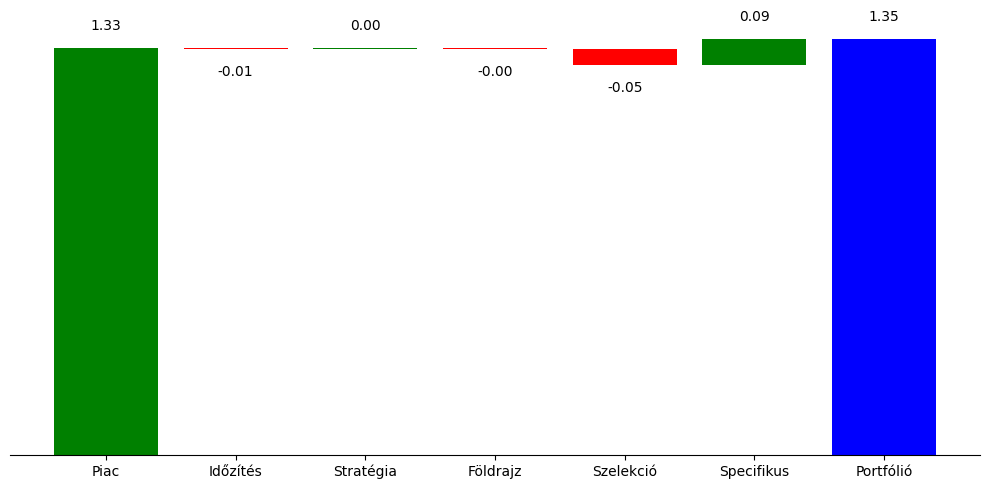

In [268]:
import matplotlib.pyplot as plt

# A bemeneti értékek
categories = ['Piac', 'Időzítés', 'Stratégia', 'Földrajz', 'Szelekció', 'Specifikus', 'Portfólió']
values = [market_moic, timing_alpha_moic, strategy_alpha_moic, geo_alpha_moic, sizing_alpha_moic, residual_alpha_moic,0]
values1 = [market_moic, timing_alpha_moic, strategy_alpha_moic, geo_alpha_moic, sizing_alpha_moic, residual_alpha_moic, port_moic]


# Kiszámítjuk a kumulált értékeket (Portfólió nélkül)
step_values = [values[0]]
for v in values[1:-1]:  # az utolsó elem a Portfólió, azt külön kezeljük
    step_values.append(step_values[-1] + v)

# A kezdőpontok (bottom) az oszlopokhoz
starts = [0] + step_values[:-1]

# Az oszlop színezése: pozitív zöld, negatív piros, végső összeg kék
colors = ['green' if v >= 0 else 'red' for v in values[:-1]] + ['blue']

# A ténylegesen megjelenített értékek (Portfólió kumulált összegként)
display_values = values[:-1] + [step_values[-1] + values[-1]]
starts += [0]  # Portfólió a 0-ról indul

# Ábra kirajzolása
plt.figure(figsize=(10, 5))
bars = plt.bar(categories, display_values, bottom=starts, color=colors)

# Értékek kiírása oszlop tetejére
for i, bar in enumerate(bars):
    yval = bar.get_height()
    bottom = bar.get_y()
    # label_val = starts[i] + yval
    label_val = values1[i]
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bottom + yval + 0.05 * (1 if yval >= 0 else -1),
             f'{label_val:.2f}', ha='center', va='bottom' if yval >= 0 else 'top')

# Formázás
# plt.title("Portfólió teljesítmény vízesés diagramja")
# plt.ylabel("Hozzájárulás (%)")
# plt.axhline(0, color='black', linewidth=0.8)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.tight_layout()
plt.savefig("waterfall_plot.pdf", dpi=300, bbox_inches='tight')
plt.show()


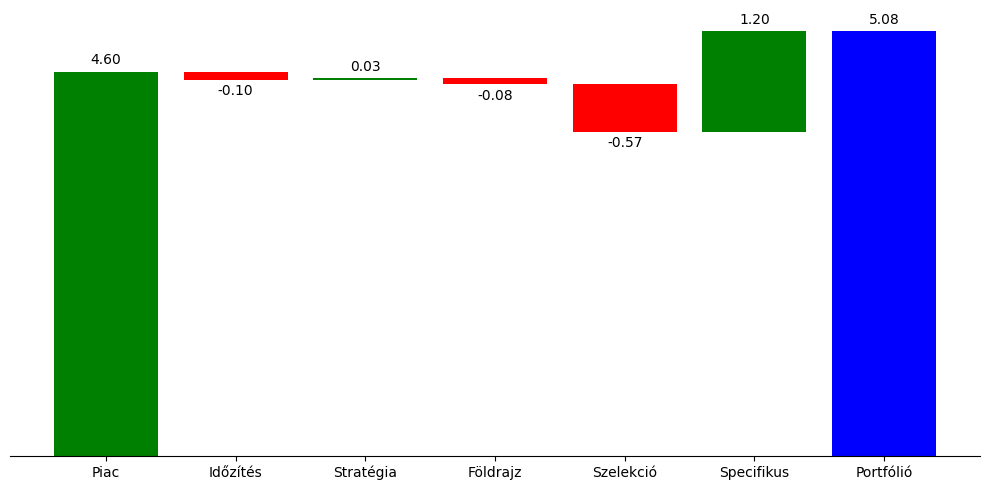

In [269]:
import matplotlib.pyplot as plt

# A bemeneti értékek
categories = ['Piac', 'Időzítés', 'Stratégia', 'Földrajz', 'Szelekció', 'Specifikus', 'Portfólió']
values =[market_irr*100, timing_alpha_irr*100, strategy_alpha_irr*100, geo_alpha_irr*100, sizing_alpha_irr*100, residual_alpha_irr*100,0]
values1 = [market_irr*100, timing_alpha_irr*100, strategy_alpha_irr*100, geo_alpha_irr*100, sizing_alpha_irr*100, residual_alpha_irr*100, port_irr*100]


# Kiszámítjuk a kumulált értékeket (Portfólió nélkül)
step_values = [values[0]]
for v in values[1:-1]:  # az utolsó elem a Portfólió, azt külön kezeljük
    step_values.append(step_values[-1] + v)

# A kezdőpontok (bottom) az oszlopokhoz
starts = [0] + step_values[:-1]

# Az oszlop színezése: pozitív zöld, negatív piros, végső összeg kék
colors = ['green' if v >= 0 else 'red' for v in values[:-1]] + ['blue']

# A ténylegesen megjelenített értékek (Portfólió kumulált összegként)
display_values = values[:-1] + [step_values[-1] + values[-1]]
starts += [0]  # Portfólió a 0-ról indul

# Ábra kirajzolása
plt.figure(figsize=(10, 5))
bars = plt.bar(categories, display_values, bottom=starts, color=colors)

# Értékek kiírása oszlop tetejére
for i, bar in enumerate(bars):
    yval = bar.get_height()
    bottom = bar.get_y()
    # label_val = starts[i] + yval
    label_val = values1[i]
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bottom + yval + 0.05 * (1 if yval >= 0 else -1),
             f'{label_val:.2f}', ha='center', va='bottom' if yval >= 0 else 'top')

# Formázás
# plt.title("Portfólió teljesítmény vízesés diagramja")
# plt.ylabel("Hozzájárulás (%)")
# plt.axhline(0, color='black', linewidth=0.8)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.tight_layout()
plt.savefig("waterfall_plot.pdf", dpi=300, bbox_inches='tight')
plt.show()
